# An Information Theory Approach to Identifying Signs of Life on Transiting Planets

This notebook produces the figures included in the paper and gives a demo of how to use the method that the paper introduces.

In [1]:
#imports
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.lines as mlines
from tqdm.notebook import trange, tqdm

from os import listdir
import math
import coronagraph as cg
import seaborn as sns


%matplotlib inline

# Read in simulated transmission spectra
First, read in a bank of simulated transmission spectra. We use transmission spectra of Earth models around different spectral classes of host stars from Kaltenegger et al. 2020 which may be found here: https://zenodo.org/record/4029370#.Y20OVuzMJhA . 

In [2]:
#change this path to match the location of the transmission spectra on your computer
path = '/Users/svannah/exoplanets/Transit_spectra_data/'

resolution = 300 #resolution = deltalambda/lambda


#read and import data
names = listdir(path)

prefix = 'Transit_spectra_FGKM_stars_through_time_'
suffix = '.txt'

#stars in in order from hottest to coldest
stars = ['F7V', 'Sun', 'G8V', 'K2V', 'K7V', 'M1A', 'M3A', 'M8A']
#epochs in data
ages = ['0.0Ga', '0.8Ga', '2.0Ga']


#wavelength ranges for visible, near-IR, and IR
viz = [0.4, 2.0]
near_ir = [2.0, 5.0]
ir = [5.0, 20.0]

# Reduce the transmission spectra
The first step in the analysis is to smooth the spectrum to a resolution of 300. 
This cell shows an exmaple of how this is done with the corongraph package, folling the demonstration found here: https://coronagraph.readthedocs.io/en/latest/notebooks/degrading_a_spectrum.html .

Text(0, 0.5, 'Effective height (km)')

/Users/svannah/local/python3.9/envs/exos/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/svannah/local/python3.9/envs/exos/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


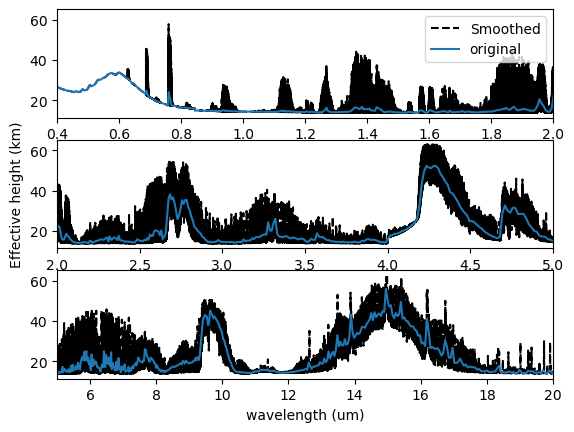

In [3]:

#import one of the transmission spectra
waves, specs = np.loadtxt(path+prefix+'F7V'+'_'+'0.0Ga'+suffix, unpack=True, skiprows=1)

lambda_min = min(waves)
lambda_max = max(waves)

#create low-res wavelength grid
lr_wavelength, lr_spacing = cg.noise_routines.construct_lam(lambda_min, lambda_max, Res=resolution)

#compute low-res spectrum
lr_spectrum = cg.downbin_spec(specs, waves, lr_wavelength, dlam=lr_spacing)

fig, axs = plt.subplots(nrows=3, sharey=True)

#plot the performance
axs[0].plot(waves, specs, color='black', linestyle='--', label='Smoothed')
axs[0].plot(lr_wavelength, lr_spectrum, label='original')
axs[0].set_xlim([0.4,2])
axs[0].legend()

axs[1].plot(waves, specs, color='black', linestyle='--')
axs[1].plot(lr_wavelength, lr_spectrum)
axs[1].set_xlim([2,5])

axs[2].plot(waves, specs, color='black', linestyle='--')
axs[2].plot(lr_wavelength, lr_spectrum)
axs[2].set_xlim([5,20])

axs[2].set_xlabel('wavelength (um)')
axs[1].set_ylabel('Effective height (km)')

Here, we load the spectra into a DataFrame and reduce their resolution. 

In [4]:
#create dataframe to hold data
spectra_df = pd.DataFrame(columns=stars, index=ages)

#create a dictionary (then data frame) to hold the simulations so that they're easy to iterate thorugh later
for i in trange(len(stars), desc='Loop through stars'):
    star = stars[i]
    #for age in ages:
    for j in trange(len(ages), desc='Loop through ages'):
        age = ages[j]
        
        #load data into dictionary
        spectrum = np.loadtxt(path+prefix+star+'_'+age+suffix, unpack=True, skiprows=1)[1]
        
        #create low-res wavelength grid
        lr_wavelength, lr_spacing = cg.noise_routines.construct_lam(lambda_min, lambda_max, Res=resolution)
        #compute low-res spectrum
        lr_spectrum = cg.downbin_spec(spectrum, waves, lr_wavelength, dlam=lr_spacing)

        spectra_df[star][age]=[lr_wavelength, lr_spectrum]
    #spectra[star] = star_spectra

#correct headers
spectra_df = spectra_df.rename(columns={'M1A':'M1Va', 'M3A':'M3Va', 'M8A':'M8Va'}, errors='raise')

#group the spectra by hotter and cooler spectral type host stars
df_hot = spectra_df[['F7V','Sun','G8V','K2V']].copy()
df_cold = spectra_df[['K7V','M1Va','M3Va','M8Va']].copy()


Loop through stars:   0%|          | 0/8 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/3 [00:00<?, ?it/s]

# Plot transmission spectra

Now we are ready to produce some figures. Since we produce several "panel plots", we first introduce a method to produce them. These subplots have 4 rows to show transmission spectra for 4 different spectral types of host star. They have 3 rows, split up to each be linear in the visible ($0.4-2.0 \mu$m), near-infrared ($2.0-5.0 \mu$m), and infrared ($5.0-20.0 \mu$m). Each row shows three "lines" (e.g. transmission spectra, or $\delta_{JS}$) for three different epochs of the evolution of Earth-like life. 

In [5]:
#to match Kaltengegger fig 2 -
#3x4 subplots. Cols split wavelength to be linear but different scales - [0.4, 2.0], [2.0, 5.0], [5,20]
#Rows split into 4 different stars (e.g. F7V, Sun, K7V, M8V)
#each plot containes 3 planetary ages (except the comparison star in Djs plots)


#lines is a dataframe of spectra (each entry is the length of the wavelength range)for n the number of lines
#line_colors is a length 3 array of colors of the 3 lines
#y_label is a string for the y-axis labels
#star label is a length 4 array of strings to label each of the 4 stars
#label_height is the y-axis height to place the label for the star for that row
def panel_plot(lines_df, line_colors, y_label, star_labels, label_height=65):
    

    #create the plot
    fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True, figsize=(17, 12))

    for row in range(4):
        axs[row,0].set_xlim([0.4,2.0])
        axs[row,1].set_xlim([2.0,5.0])
        axs[row,2].set_xlim([5.0,20.0])

        axs[row,2].text(16.5, label_height, star_labels[row], fontsize='xx-large', c='gray')
        axs[row,0].set_ylabel(y_label, fontsize='14')
    

    for col in range(3):
        axs[3,col].set_xlabel(r'Wavelength ($\mu m$)', fontsize='14')
        axs[3,col].set_xlabel(r'Wavelength ($\mu m$)', fontsize='14')
        axs[3,col].set_xlabel(r'Wavelength ($\mu m$)', fontsize='14')


    ages = ['0.0Ga', '0.8Ga', '2.0Ga']
    age_labels = [r'Modern Earth 21% O$_2$ (1 PAL)', r'Neoproterozoic Earth (10% PAL O$_2$)', r'Paleo- and Meso-proterozoic Earth (1% PAL O$_2$)']

    for col in range(3):
        for row in range(4):
            for a, age in enumerate(ages):

                waves_df, spec_df = lines_df[star_labels[row]][age]
                indices = [[0,find_nearest(waves_df, 2.0)], [find_nearest(waves_df, 2.0), find_nearest(waves_df, 5.0)], [find_nearest(waves_df, 5.0), find_nearest(waves_df, 20.0)]]
                line = axs[row, col].plot(waves_df[indices[col][0]:indices[col][1]], spec_df[indices[col][0]:indices[col][1]], color=line_colors[a], linewidth=1, label=age_labels[a])


    lines = [mlines.Line2D([],[], color=line_colors[i], label=age_labels[i]) for i in range(3)]

    plt.figlegend(handles=lines, bbox_to_anchor=(0.5, 1.00), loc='upper center', shadow=True, ncol=5)


    return fig, axs


#find index of value in array closest to a given value
#modified from https://www.codegrepper.com/code-examples/python/find+index+of+nearest+value+python
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()

    return idx

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


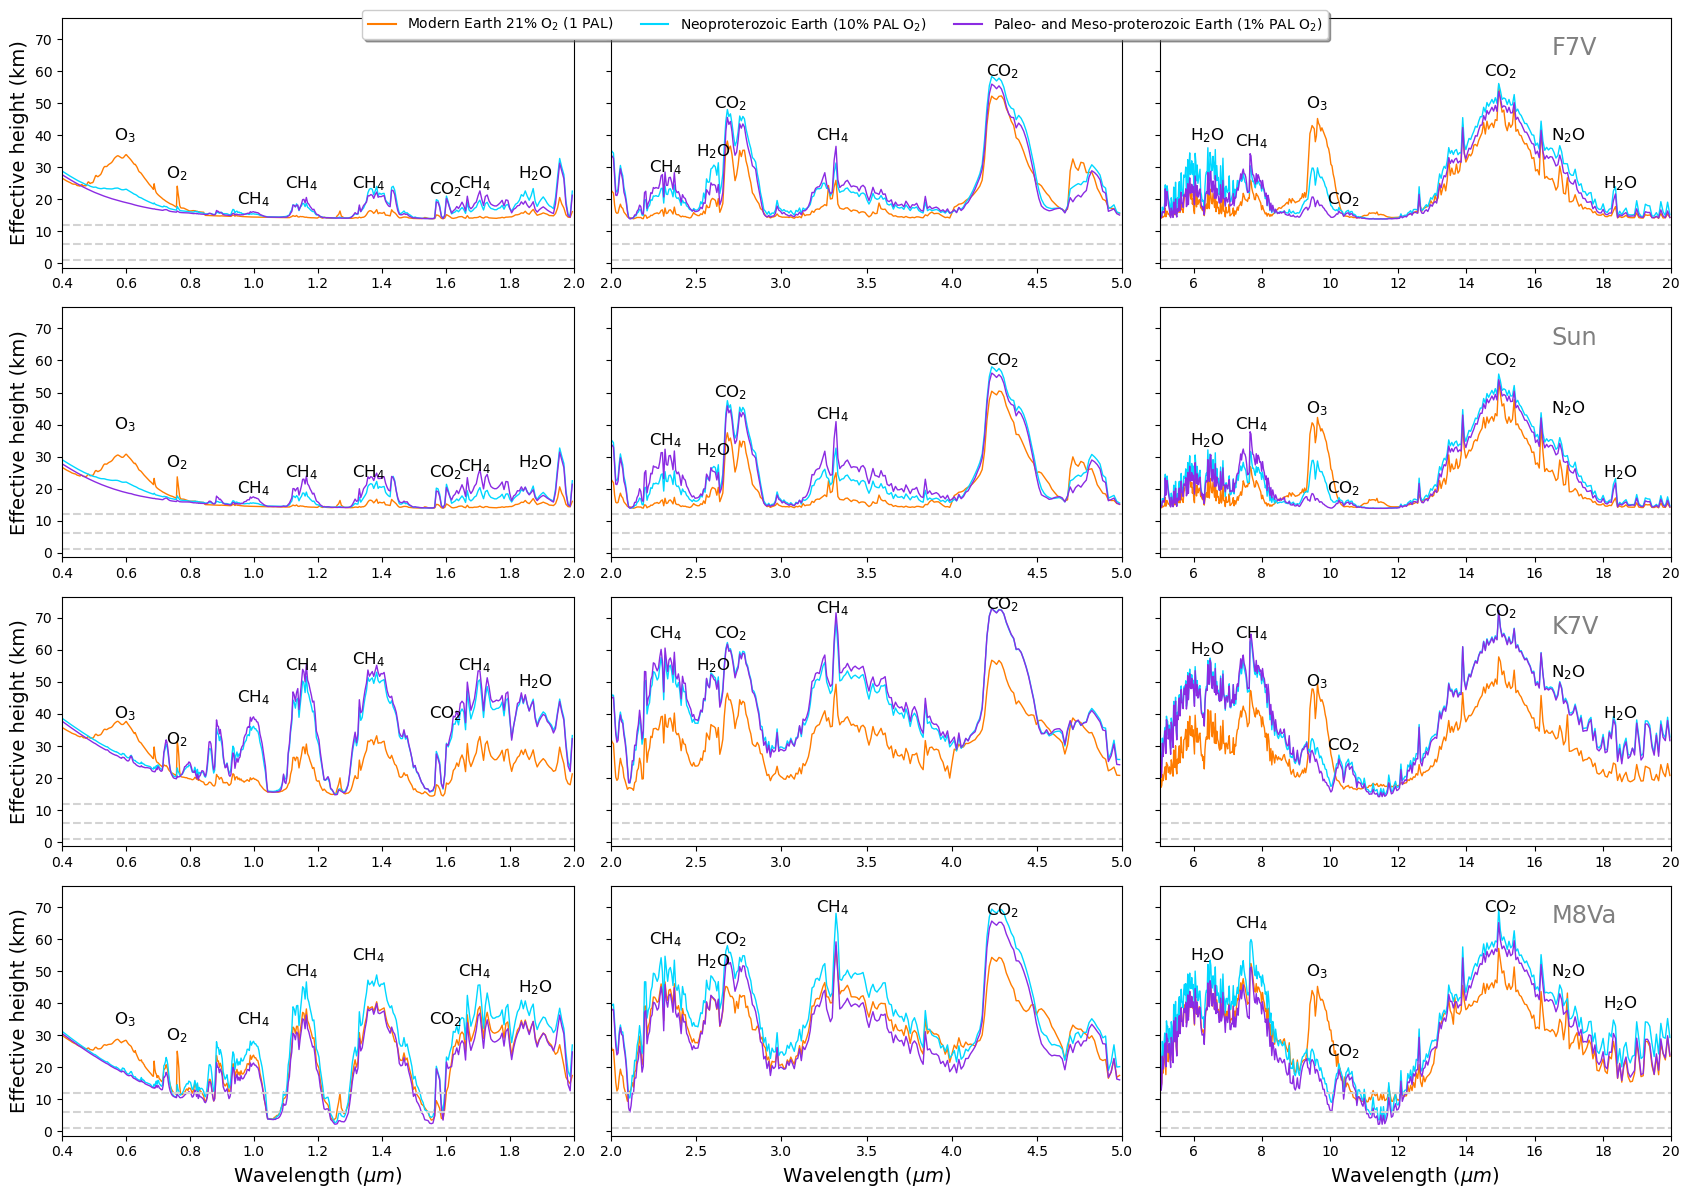

In [6]:
#This cell produces the supplementary material included in the paper. 
#It shows a subset of the transmission spectra after reducing their resolution,
#but before the information theory analysis is applied

#choose colors from seaborn colorwheel
standard_clr = [1,9,4]

fig3, fig3_axs = panel_plot(spectra_df, [sns.color_palette('bright')[i] for i in standard_clr], 'Effective height (km)', ['F7V', 'Sun', 'K7V', 'M8Va'])

#plot cloud heights
for row in range(4):
    for col in range(3):
        fig3_axs[row, col].axhline(1, color='lightgray', linestyle='dashed')
        fig3_axs[row, col].axhline(6, color='lightgray', linestyle='dashed')
        fig3_axs[row, col].axhline(12, color='lightgray', linestyle='dashed')



###############################################################################################################
#
#                       Add line labels by hand to make them easier to read
#
###############################################################################################################
fig3_axs[0,0].text((0.74+0.45)/2, 40, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(0.76, 28, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(1.00, 20, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(1.15, 25, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(1.36, 25, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(1.69, 25, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(1.6, 23, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,0].text(1.88, 28, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[1,0].text((0.74+0.45)/2, 40, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(0.76, 28, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(1.00, 20, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(1.15, 25, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(1.36, 25, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(1.69, 27, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(1.6, 25, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,0].text(1.88, 28, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[2,0].text((0.74+0.45)/2, 40, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(0.76, 32, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(1.00, 45, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(1.15, 55, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(1.36, 57, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(1.69, 55, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(1.6, 40, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,0].text(1.88, 50, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[3,0].text((0.74+0.45)/2, 35, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(0.76, 30, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(1.00, 35, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(1.15, 50, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(1.36, 55, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(1.69, 50, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(1.6, 35, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,0].text(1.88, 45, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')


###############################################################################################################
#Second column

fig3_axs[0,1].text(2.32, 30, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,1].text(2.6, 35, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,1].text(2.7, 50, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,1].text(3.3, 40, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,1].text(4.3, 60, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[1,1].text(2.32, 35, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,1].text(2.6, 32, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,1].text(2.7, 50, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,1].text(3.3, 43, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,1].text(4.3, 60, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[2,1].text(2.32, 65, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,1].text(2.6, 55, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,1].text(2.7, 65, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,1].text(3.3, 73, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,1].text(4.3, 74, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[3,1].text(2.32, 60, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,1].text(2.6, 53, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,1].text(2.7, 60, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,1].text(3.3, 70, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,1].text(4.3, 69, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

###############################################################################################################
#Third column

fig3_axs[0,2].text(6.4, 40, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,2].text(7.7, 38, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,2].text(9.6, 50, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,2].text(10.4, 20, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,2].text(15, 60, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,2].text(17, 40, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[0,2].text(18.5, 25, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')


fig3_axs[1,2].text(6.4, 35, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,2].text(7.7, 40, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,2].text(9.6, 45, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,2].text(10.4, 20, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,2].text(15, 60, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,2].text(17, 45, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[1,2].text(18.5, 25, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[2,2].text(6.4, 60, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,2].text(7.7, 65, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,2].text(9.6, 50, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,2].text(10.4, 30, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,2].text(15, 72, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,2].text(17, 53, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[2,2].text(18.5, 40, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig3_axs[3,2].text(6.4, 55, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,2].text(7.7, 65, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,2].text(9.6, 50, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,2].text(10.4, 25, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,2].text(15, 70, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,2].text(17, 50, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig3_axs[3,2].text(18.5, 40, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')


plt.savefig('raw_data.eps')

plt.show()

# Quantify how Earth-like an exoplanet is
## Compute Jensen-Shannon divergence of the transmission spectra

Now the transmission spectra are prepared, we're ready to quantify how Earth-like a transmission spectrum is using Jensen-Shannon divergence. Suppose you have an observed transmission spectrum (here, effective height of the atmosphere as a function of wavelength), $h_\lambda$, and a Earth-model spectrum, $g_\lambda$, that you'd like to compare it to. We first compute the modal fractions, $p_\lambda$ and $q_\lambda$, of the two transmission spectra as
$$p_\lambda = \frac{h_\lambda}{\sum h_\lambda}$$
$$q_\lambda = \frac{g_\lambda}{\sum g_\lambda}.$$

The mean of the two modal fractions is then 

$$r_\lambda = \frac{1}{2}(p_\lambda + q_\lambda).$$

The Jensen-Shannon divergence of the two spectra is given by 

$$\mathcal{D}_{JS} = \frac{1}{2} \sum p_\lambda log(\frac{p_\lambda}{r_\lambda}) +  \frac{1}{2} \sum q_\lambda log(\frac{q_\lambda}{r_\lambda}). $$



In [7]:
#This cell is the Djs calculation
def get_djs(spec1, spec2):

    #compute modal fractions
    p, q = spec1/sum(spec1), spec2/sum(spec2)
    r = 1/2 * (p+q)
    
    Djs = 1/2 * np.sum(p*np.log(p/r)) + 1/2 * np.sum(q*np.log(q/r))
    
    return Djs

In our work, we compare all the simulated transmission spectra to an Earth standard. The planets around hotter stars are compared to a modern Earth model around the Sun, while those around cooler stars are compared to a modern Earth model around an M1 star. 

In [8]:
#calculating Djs compared to Earth for each planet
earth = spectra_df['Sun']['0.0Ga'][1]
djs_df_hot = df_hot.applymap(lambda spec: get_djs(spec[1], earth))
djs_df_cold = df_cold.applymap(lambda spec: get_djs(spec[1], spectra_df['M1Va']['0.0Ga'][1]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


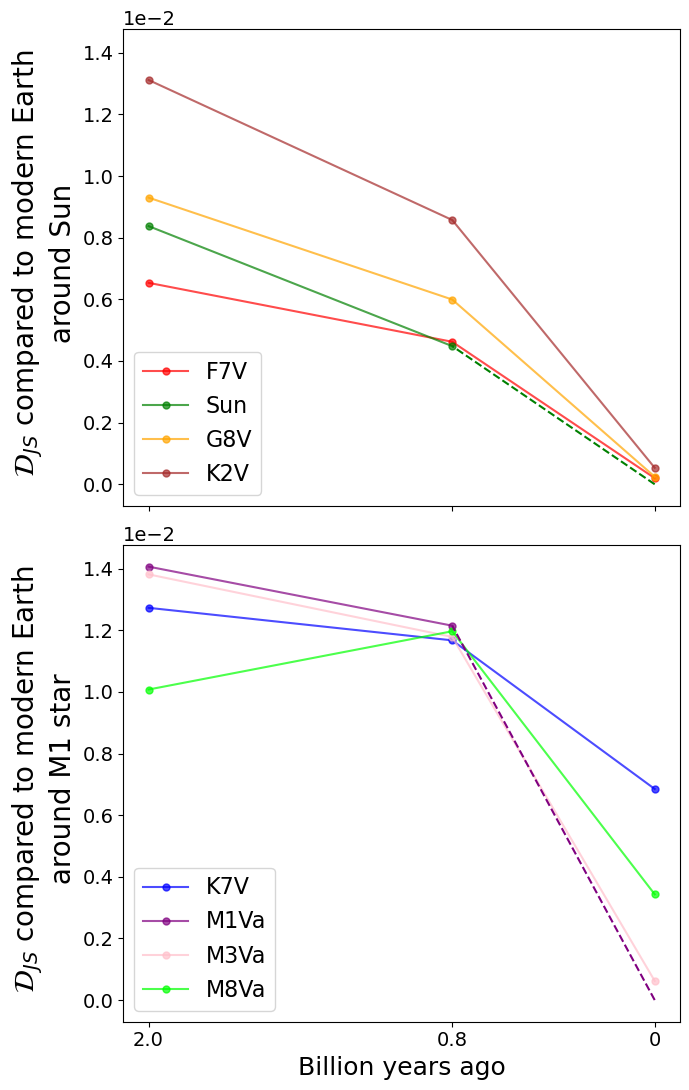

In [9]:
#This cell produces Fig. 1 in our Letter

#compute the Djs for each planet relative to modern Earth standard
fig, axs = plt.subplots(nrows=2, sharey=True, sharex=True, figsize=(7, 11), tight_layout=True)


years = [0, 0.8, 2]
axs[0].plot(years, djs_df_hot['F7V'], label='F7V', marker='.', markersize=10, alpha=0.7, color='red')
axs[0].plot(years[1:], djs_df_hot['Sun'][1:], label='Sun', marker='.', markersize=10, alpha=0.7, color='green')
axs[0].plot(years, djs_df_hot['G8V'], label='G8V', marker='.', markersize=10, alpha=0.7, color='orange')
axs[0].plot(years, djs_df_hot['K2V'], label='K2V', marker='.', markersize=10, alpha=0.7, color='brown')
#add dashed line from Sun at 0.8Gya to 0Gya (0Djs) to guide the eye
axs[0].plot([0,0.8],[0,djs_df_hot['Sun'][1]], linestyle='dashed', color='green')


axs[1].plot(years, djs_df_cold['K7V'], label='K7V', marker='.', markersize=10, alpha=0.7, color='blue')
axs[1].plot(years[1:], djs_df_cold['M1Va'][1:], label='M1Va', marker='.', markersize=10, alpha=0.7, color='purple')
axs[1].plot(years, djs_df_cold['M3Va'], label='M3Va', marker='.', markersize=10, alpha=0.7, color='pink')
axs[1].plot(years, djs_df_cold['M8Va'], label='M8Va', marker='.', markersize=10, alpha=0.7, color='lime')
#add dashed line from 0.8Gya to 0Gya for M1 star
axs[1].plot([0,0.8],[0,djs_df_cold['M1Va'][1]], linestyle='dashed', color='purple')


axs[0].set_ylabel(' $\mathcal{D}_{JS}$ compared to modern Earth\n around Sun', fontsize=20)
axs[1].set_ylabel(' $\mathcal{D}_{JS}$ compared to modern Earth\n around M1 star', fontsize=20)

axs[1].set_xlabel('Billion years ago', fontsize=18)

axs[0].set_xticks([0,0.8,2], labels=['0', '0.8', '2.0'])
axs[1].set_xticks([0,0.8,2], labels=['0', '0.8', '2.0'])


axs[0].invert_xaxis()

axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

axs[0].yaxis.offsetText.set_fontsize(14)
axs[1].yaxis.offsetText.set_fontsize(14)

axs[0].legend(fontsize=16, loc=3)
axs[1].legend(fontsize=16, loc=3)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


plt.savefig('djs_split_stars.eps')

# Identifying biosignatures
## Compute Jensen-Shannon divergence density
Jensen-Shannon divergence is a global metric. To quantify the Earth-likeness of a molecular feature (e.g. a biosignature gas), we introduced the Jensen-Shannon divergence density as function of wavelength, 

$$ \delta_{JS, \nu} = \frac{1}{2} p_\lambda log(\frac{p_\lambda}{r_\lambda}) +  \frac{1}{2}q_\lambda log(\frac{q_\lambda}{r_\lambda}). $$

In [10]:
#calculate Djs *density*
#this is identical to the get_djs() method above but without the sum 
def get_djs_density(spec1, spec2):
    
    #spec2 = earth
    p, q = spec1/sum(spec1), spec2/sum(spec2)
    r = 1/2 * (p+q)
    
    Djs_dens = 1/2 * p*np.log(p/r) + 1/2 * q*np.log(q/r)

    #wave array is the same for all the planets
    waves = spectra_df['Sun']['0.0Ga'][0]

    return waves, Djs_dens

In [11]:
#this calculates the Djs density of every spectrum in our dataset (about different stars & through different ages)

#compare all transmission spectra to modern Earth model around solar-type host
djs_dens_df = spectra_df.applymap(lambda spec: get_djs_density(spec[1], earth)) 
#compare transmission spectra to modern Earth model around host star standard (Sun), and cold star standard (M1)
djs_dens_df_hot = djs_dens_df 
djs_dens_df_cold = df_cold.applymap(lambda spec: get_djs_density(spec[1], spectra_df['M1Va']['0.0Ga'][1]))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


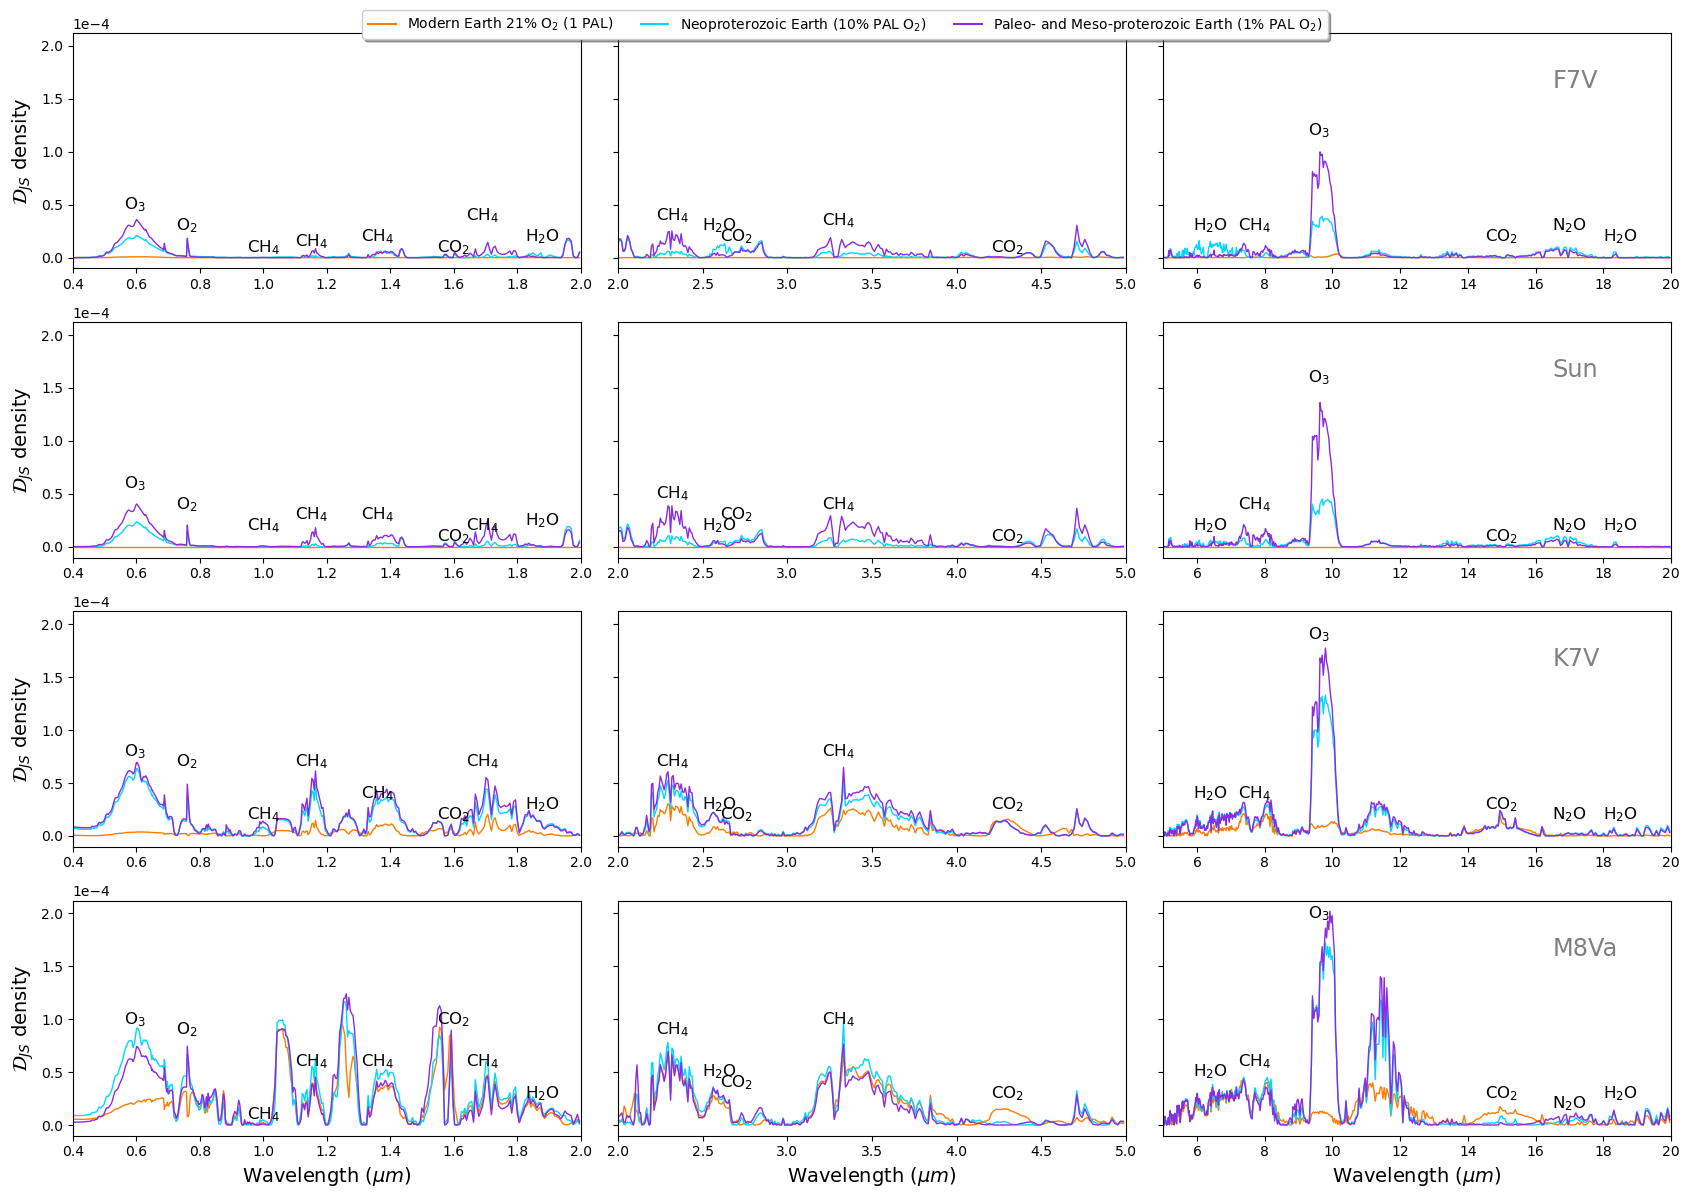

In [12]:
#This cell produces figure 2 in the Letter

fig4, fig4_axs = panel_plot(djs_dens_df, [sns.color_palette('bright')[i] for i in standard_clr], r'$\mathcal{D}_{JS}$ density', ['F7V', 'Sun', 'K7V', 'M8Va'], label_height=1.6e-4)


###############################################################################################################
#
#                       Add line labels by hand to make them easier to read
#
###############################################################################################################
fig4_axs[0,0].text((0.74+0.45)/2, 0.5e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(0.76, 0.3e-4, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(1.00, 0.1e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(1.15, 0.15e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(1.36, 0.2e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(1.6, 0.1e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(1.69, 0.4e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,0].text(1.88, 0.2e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[1,0].text((0.74+0.45)/ 2,0.6e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(0.76, 0.4e-4, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(1.00, 0.2e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(1.15, 0.3e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(1.36, 0.3e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(1.6, 0.1e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(1.69, 0.2e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,0].text(1.88, 0.25e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[2,0].text((0.74+0.45)/2, 0.8e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(0.76, 0.7e-4, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(1.00, 0.2e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(1.15, 0.7e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(1.36, 0.4e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(1.6, 0.2e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(1.69, 0.7e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,0].text(1.88, 0.3e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[3,0].text((0.74+0.45)/2, 1.0e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(0.76, 0.9e-4, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(1.00, 0.1e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(1.15, 0.6e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(1.36, 0.6e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(1.6, 1.0e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(1.69, 0.6e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,0].text(1.88, 0.3e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')


###############################################################################################################
#Second column

fig4_axs[0,1].text(2.32, 0.4e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,1].text(2.6, 0.3e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,1].text(2.7, 0.2e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,1].text(3.3, 0.35e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,1].text(4.3, 0.1e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[1,1].text(2.32, 0.5e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,1].text(2.6, 0.2e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,1].text(2.7, 0.3e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,1].text(3.3, 0.4e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,1].text(4.3, 0.1e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[2,1].text(2.32, 0.7e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,1].text(2.6, 0.3e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,1].text(2.7, 0.2e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,1].text(3.3, 0.8e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,1].text(4.3, 0.3e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[3,1].text(2.32, 0.9e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,1].text(2.6, 0.5e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,1].text(2.7, 0.4e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,1].text(3.3, 1.0e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,1].text(4.3, 0.3e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')

###############################################################################################################
#Third column

fig4_axs[0,2].text(6.4, 0.3e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,2].text(7.7, 0.3e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,2].text(9.6, 1.2e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
#fig4_axs[0,2].text(10.4, 0.2e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,2].text(15, 0.2e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,2].text(17, 0.3e-4, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[0,2].text(18.5, 0.2e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')


fig4_axs[1,2].text(6.4, 0.2e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,2].text(7.7, 0.4e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,2].text(9.6, 1.6e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
#fig4_axs[1,2].text(10.4, 0.2e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,2].text(15, 0.1e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,2].text(17, 0.2e-4, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[1,2].text(18.5, 0.2e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[2,2].text(6.4, 0.4e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,2].text(7.7, 0.4e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,2].text(9.6, 1.9e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
#fig4_axs[2,2].text(10.4, 0.4e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,2].text(15, 0.3e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,2].text(17, 0.2e-4, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[2,2].text(18.5, 0.2e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

fig4_axs[3,2].text(6.4, 0.5e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,2].text(7.7, 0.6e-4, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,2].text(9.6, 2.0e-4, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
#fig4_axs[3,2].text(10.4, 1.3e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,2].text(15, 0.3e-4, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,2].text(17, 0.2e-4, r'N$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
fig4_axs[3,2].text(18.5, 0.3e-4, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')

#fig4_axs[0,0].ticklabel_format(axis='y', scilimits=[-2,3])

plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('Djs_density.eps')

plt.show()



The plot above compares each transmission spectrum to a modern Earth model around a solar-type host star. This allows us to illustrate the method's ability to trace changes in the transmission spectra due to both the evolution of life on the planet, and differences in stellar irradiance. However, the spectral type of the host star of an observed exoplanet may be easily known. The appropriate model Earth standard for an observed planet should therefore be one with a similar spectral type to the true host star. This may be chosen from the bank of simulated transmission spectra in Kaltenegger et al. 2020. The figure below shows the importance of this, and how the method should be used.

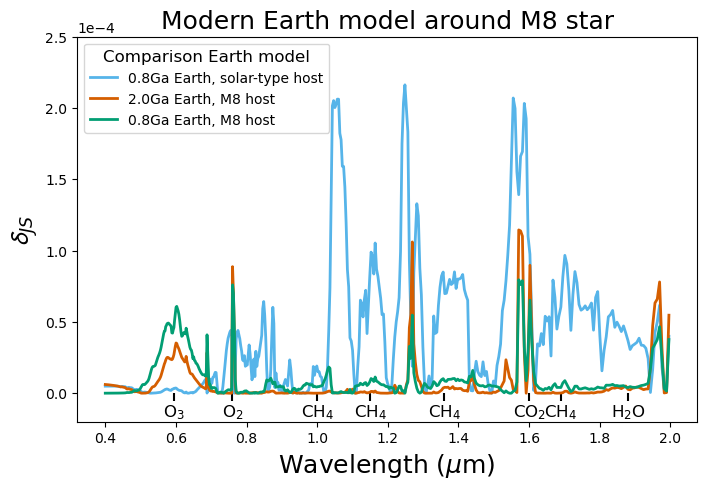

In [13]:
#This cell produces Figure 3 in our Letter. 
#It shows how Djs density reduces when a transmission spectrum is compared an Earth standard with the appropriate...
#... spectral class of of host star

fig, ax = plt.subplots(figsize=(8, 5))

#index for upper limit of spectrum. Here, we use only the visible range, so go up to 2.0um 
upper_limit = find_nearest(spectra_df['M8Va']['0.0Ga'][0], 2)

ax.plot(spectra_df['M8Va']['0.0Ga'][0][:upper_limit], get_djs_density(spectra_df['M8Va']['0.0Ga'][1][:upper_limit], spectra_df['Sun']['0.8Ga'][1][:upper_limit])[1], label='0.8Ga Earth, solar-type host', linewidth=2, color=sns.color_palette('colorblind')[9])
ax.plot(spectra_df['M8Va']['0.0Ga'][0][:upper_limit], get_djs_density(spectra_df['M8Va']['0.0Ga'][1][:upper_limit], spectra_df['M8Va']['2.0Ga'][1][:upper_limit])[1], label='2.0Ga Earth, M8 host', linewidth=2, color=sns.color_palette('colorblind')[3])
ax.plot(spectra_df['M8Va']['0.0Ga'][0][:upper_limit], get_djs_density(spectra_df['M8Va']['0.0Ga'][1][:upper_limit], spectra_df['M8Va']['0.8Ga'][1][:upper_limit])[1], label='0.8Ga Earth, M8 host', linewidth=2, color=sns.color_palette('colorblind')[2])
ax.legend(title='Comparison Earth model',title_fontproperties={'size':12})#, 'weight':'bold'})#, title_fontsize='x-large')

plt.title('Modern Earth model around M8 star', fontsize=18)
ax.set_ylabel('$\mathcal{\delta}_{JS}$', fontsize=18)
ax.set_xlabel('Wavelength ($\mu$m)', fontsize=18)
#ax.set_xscale('log')


plt.ylim([-2e-5, 2.5e-4])
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


ax.text((0.74+0.45)/2, -1.3e-5, r'O$_3$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter((0.74+0.45)/2, -0.3e-5, marker='|', color='black')
ax.text(0.76, -1.3e-5, r'O$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(0.76, -0.3e-5, marker='|', color='black')
ax.text(1.00, -1.3e-5, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(1.00, -0.3e-5, marker='|', color='black')
ax.text(1.15, -1.3e-5, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(1.15, -0.3e-5, marker='|', color='black')
ax.text(1.36, -1.3e-5, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(1.36, -0.3e-5, marker='|', color='black')
ax.text(1.69, -1.3e-5, r'CH$_4$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(1.69, -0.3e-5, marker='|', color='black')
ax.text(1.6,-1.3e-5, r'CO$_2$', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(1.6, -0.3e-5, marker='|', color='black')
ax.text(1.88, -1.3e-5, r'H$_2$O', fontsize='large', horizontalalignment='center', verticalalignment='center')
ax.scatter(1.88, -0.3e-5, marker='|', color='black')

# Further demos

These plots demonstrate the $\delta_{JS, \nu}$ when separating the Earth models around hotter stars and cooler stars to compare to an Earth standard with a solar-type host star and an M1-type host star, respectively, as in Figure 1. 

In [14]:
#This function makes it easier to plot absorption line labels,...
#...but the results are not as easy to read as plotting by hand 
#also labels fewer lines so that labels don't overlap as much

#to use this, you'll need to specify a height on the figure for all the labels to go
def add_line_labels(axis, height):
    
    strong_O2 = np.array([0.76])
    strong_O3 = np.array([9.6, (.74+.45)/2])
    strong_CH4 = np.array([7.7, 3.3, 2.32, 1.69, 1.00, 0.89])

    axs_min, axs_max = min(axis.get_xticks()), max(axis.get_xticks())

    #plot absorption line
    for i in strong_O2:
        if i > axs_min and i < axs_max:
            axis.text(i, height, 'O2', fontsize='small', horizontalalignment='center', verticalalignment='center')
    for i in strong_O3:
        if i > axs_min and i < axs_max:
            axis.text(i, height, 'O3', fontsize='small', horizontalalignment='center', verticalalignment='center')
    for i in strong_CH4:
        if i > axs_min and i < axs_max:
            axis.text(i, height, 'CH4', fontsize='small', horizontalalignment='center', verticalalignment='center')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


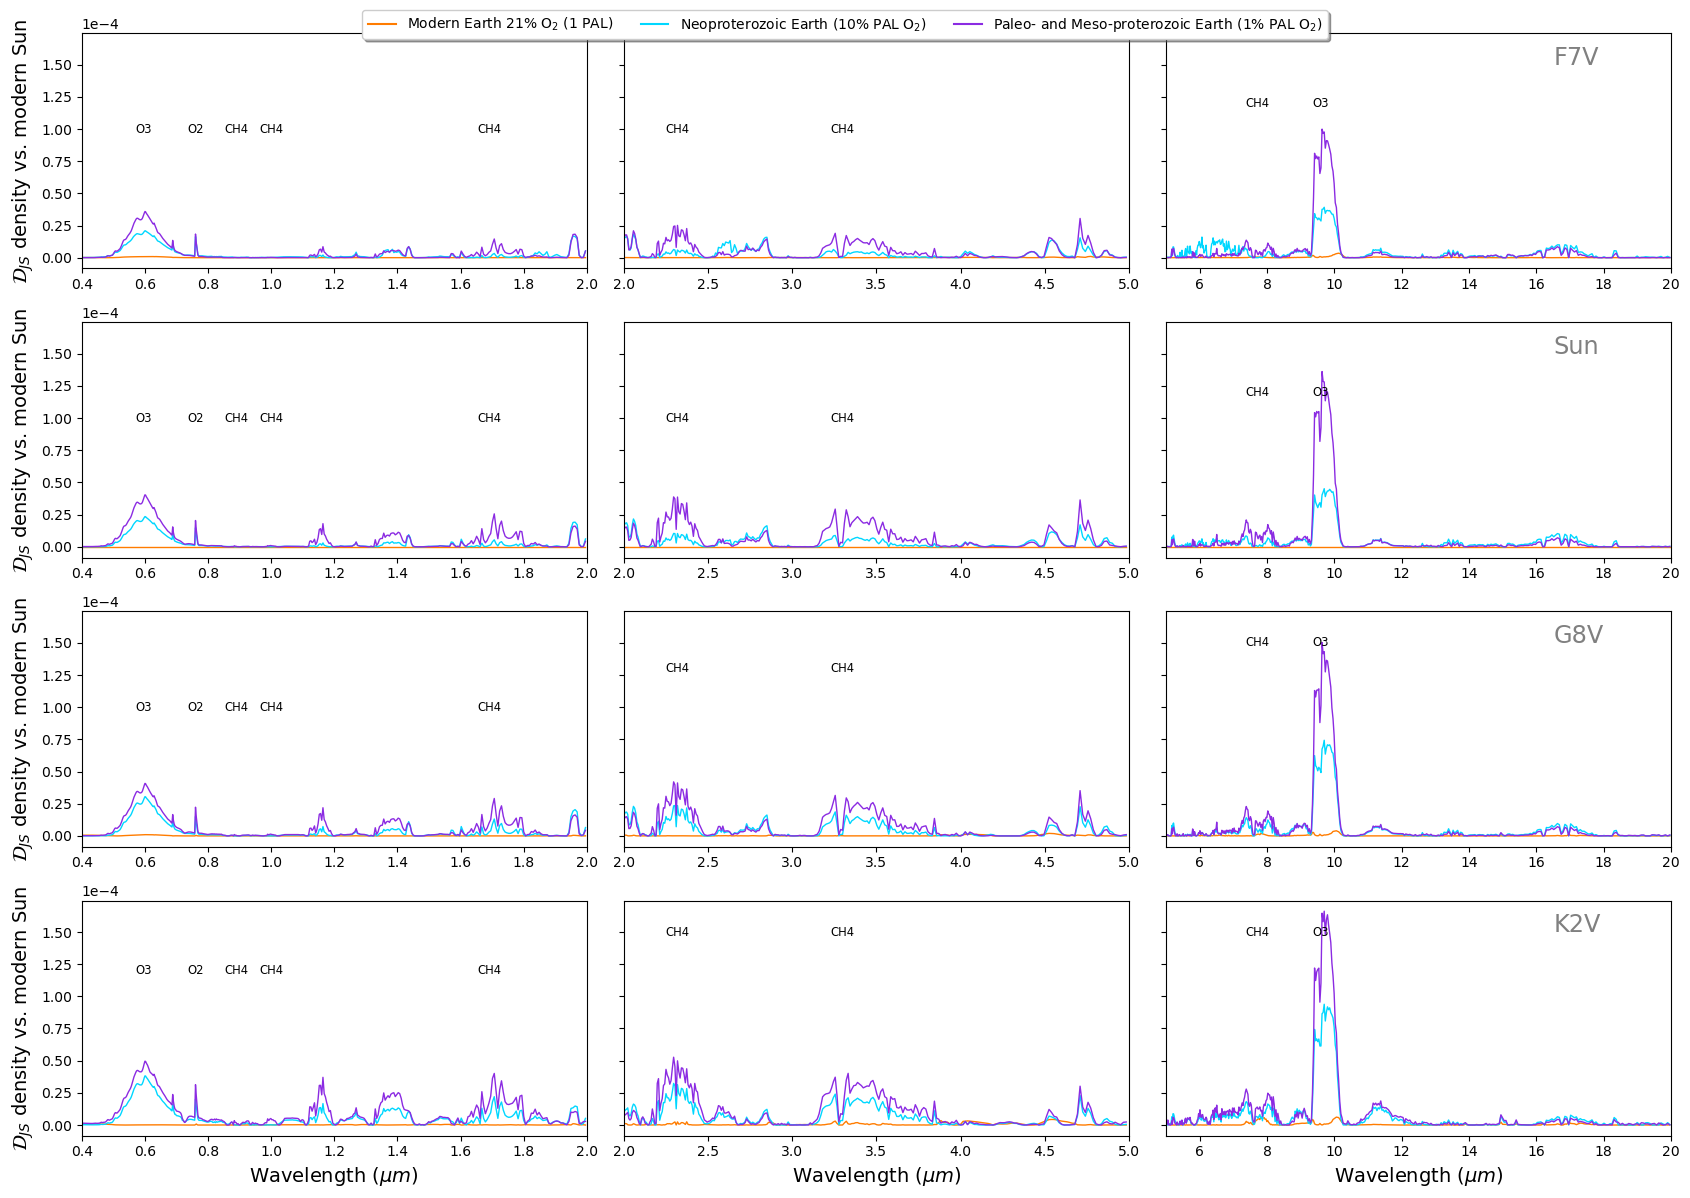

In [15]:
#this figure compares the Earth models around hotter host-stars to an Earth-standard around the Sun,...
#... as in the top panel of figure 1

fig5, fig5_axs = panel_plot(djs_dens_df_hot, [sns.color_palette('bright')[i] for i in standard_clr],
                            r'$\mathcal{D}_{JS}$ density vs. modern Sun', ['F7V', 'Sun', 'G8V', 'K2V'], 
                            label_height=1.5e-4)

add_line_labels(fig5_axs[0,0], 0.0001)
add_line_labels(fig5_axs[1,0], 0.0001)
add_line_labels(fig5_axs[2,0], 0.0001)
add_line_labels(fig5_axs[3,0], 0.00012)

add_line_labels(fig5_axs[0,1], 0.0001)
add_line_labels(fig5_axs[1,1], 0.0001)
add_line_labels(fig5_axs[2,1], 0.00013)
add_line_labels(fig5_axs[3,1], 0.00015)

add_line_labels(fig5_axs[0,2], 0.00012)
add_line_labels(fig5_axs[1,2], 0.00012)
add_line_labels(fig5_axs[2,2], 0.00015)
add_line_labels(fig5_axs[3,2], 0.00015)

fig5_axs[0,0].ticklabel_format(axis='y', scilimits=[-2,3])

plt.savefig('djs_dens_hot_stars.eps')

plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


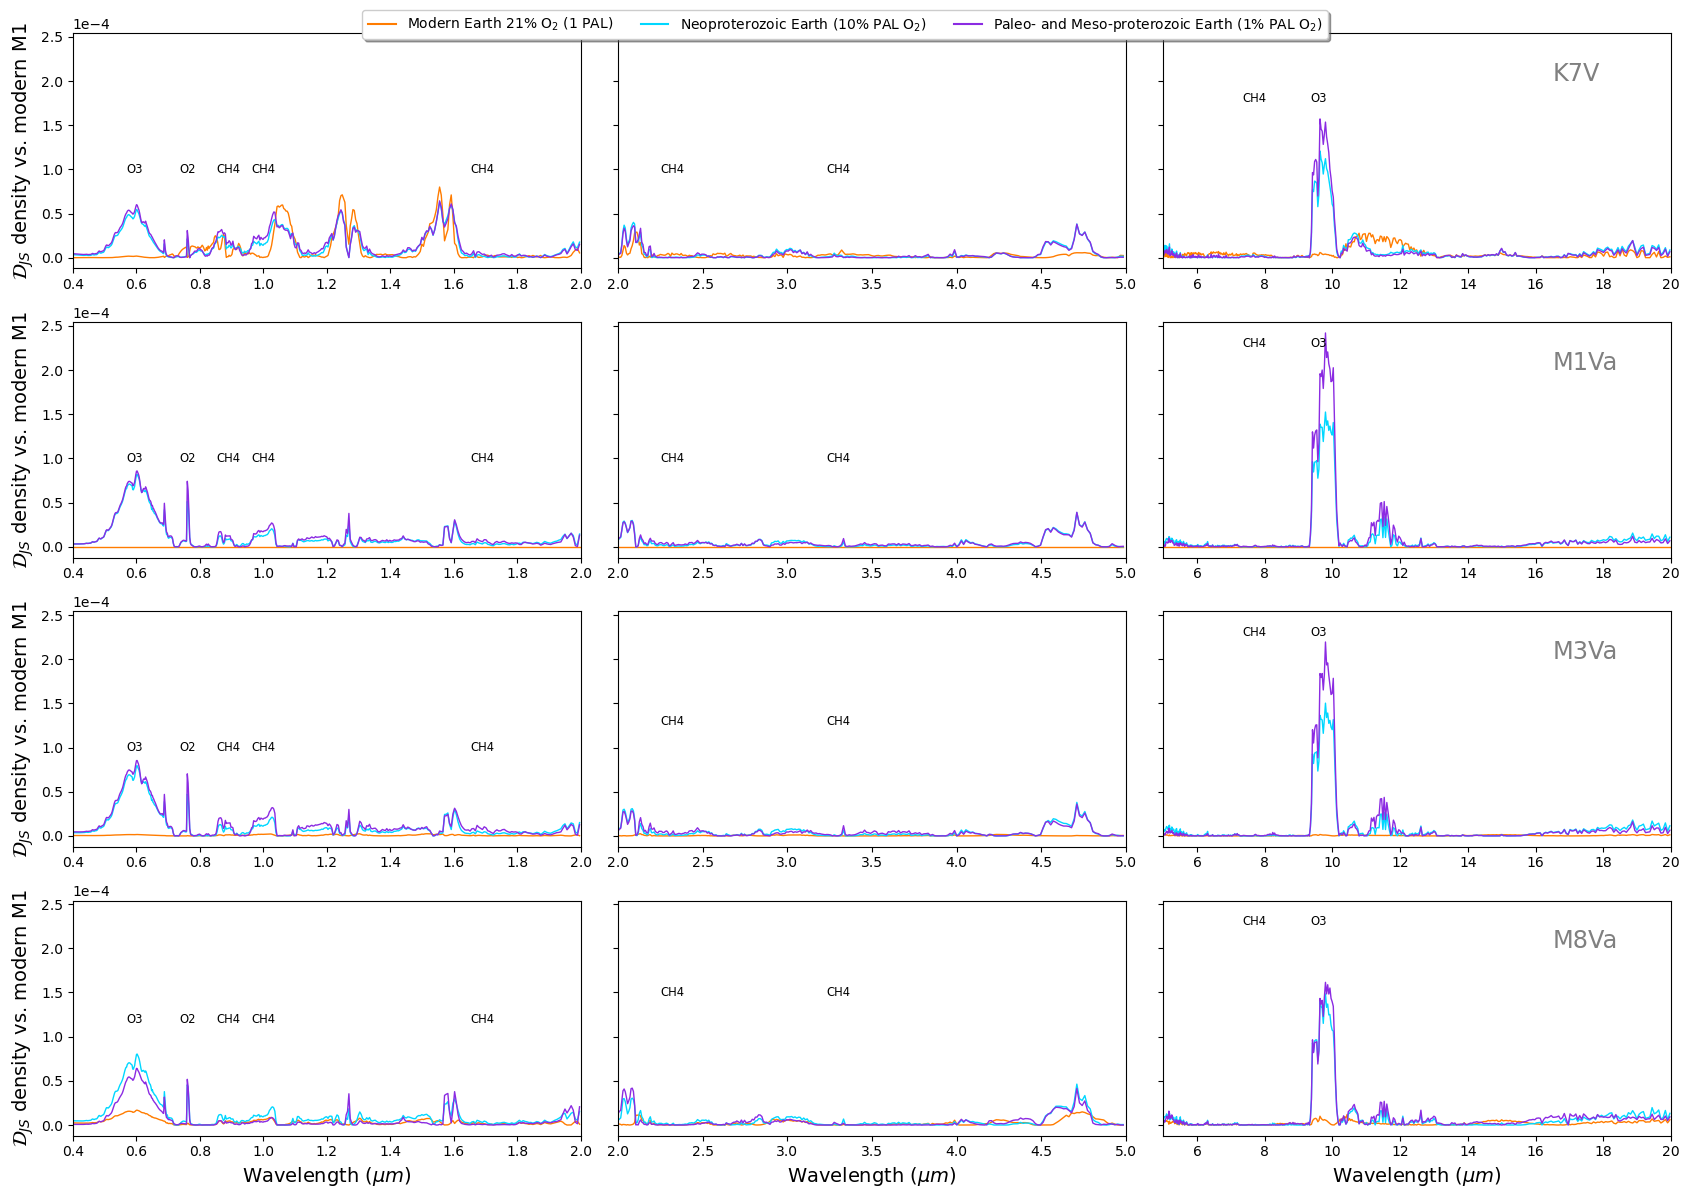

In [16]:
#this figure compares the Earth models around cooler host-stars to an Earth-standard around an M1 star,...
#... as in the bottom panel of figure 1


fig6, fig6_axs = panel_plot(djs_dens_df_cold, [sns.color_palette('bright')[i] for i in standard_clr], 
                            r'$\mathcal{D}_{JS}$ density vs. modern M1', ['K7V', 'M1Va', 'M3Va', 'M8Va'], 
                            label_height=2e-4)

add_line_labels(fig6_axs[0,0], 0.0001)
add_line_labels(fig6_axs[1,0], 0.0001)
add_line_labels(fig6_axs[2,0], 0.0001)
add_line_labels(fig6_axs[3,0], 0.00012)

add_line_labels(fig6_axs[0,1], 0.0001)
add_line_labels(fig6_axs[1,1], 0.0001)
add_line_labels(fig6_axs[2,1], 0.00013)
add_line_labels(fig6_axs[3,1], 0.00015)

add_line_labels(fig6_axs[0,2], 0.00018)
add_line_labels(fig6_axs[1,2], 0.00023)
add_line_labels(fig6_axs[2,2], 0.00023)
add_line_labels(fig6_axs[3,2], 0.00023)

fig6_axs[0,0].ticklabel_format(axis='y', scilimits=[-2,3])


plt.savefig('djs_dens_cold_stars.eps')

plt.show()


